In [91]:
import time
import os
import nltk
import torch

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [92]:
%matplotlib inline


In [93]:
ran_state = 42
data_dir = '~/folders/Documents/study/NLP_PJ/philo/dataset'
dl_folder = '~/folders/Documents/study/NLP_PJ/philo/dataset/dl/transformers'
destination_folder = '~/folders/Documents/study/NLP_PJ/philo/results'
filenames = [
    'kant.txt', 
    'aristotle.txt', 
    'plato.txt', 
    'hume.txt',
    'nietzsche.txt'
    ]

[os.path.join(data_dir, file) for file in filenames]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [94]:
csv_file = 'sentences.csv'
data_csv = os.path.join(data_dir, csv_file)
philo_df = pd.read_csv(data_csv).sample(frac = 1)
philo_df = philo_df.iloc[:len(philo_df)//2]
NUM_LABELS = len(philo_df.author.unique())
philo_df.head()

,label,sentence,author,word_count,mean_word_length,stop_words_ratio,stop_words_count,ADJ_count,ADV_count,ADP_count,...,X_count,INTJ_count,CONJ_count,CCONJ_count,SCONJ_count,PROPN_count,NOUN_count,PRON_count,PART_count,VERB_count
19439,1,"The parliament accordingly, in the ensuing yea...",Hume,17,6.00,47.06,8,2,1,1,...,0,0,0,1,0,0,3,1,0,3
7039,0,Now in experience our perceptions come togethe...,Kant,60,5.75,61.67,37,2,7,9,...,0,0,0,2,3,0,15,1,1,6
18552,1,"Knights and esquires, says the Dictum of Keni...",Hume,42,4.64,54.76,23,2,1,4,...,0,0,0,2,1,3,10,2,1,5
29084,1,"It is come to this plain question, whether the...",Hume,50,5.08,56.00,28,3,2,7,...,0,0,0,2,2,1,12,2,2,5
87783,3,"More truly implied, namely, that Practical Wis...",Aristotle,10,6.40,40.00,4,0,3,1,...,0,0,0,0,1,2,2,0,0,1


In [95]:
enc_aut = {}
aut_label = philo_df[['author', 'label']].drop_duplicates().reset_index(drop=True).to_dict('record')
for k in aut_label:
    enc_aut[k['label']] = k['author']
enc_aut    

/Users/bettyld/opt/anaconda3/envs/py37/lib/python3.8/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


{1: 'Hume', 0: 'Kant', 3: 'Aristotle', 2: 'Plato', 4: 'Nietzsche'}

label               0
sentence            0
author              0
word_count          0
mean_word_length    0
stop_words_ratio    0
stop_words_count    0
ADJ_count           0
ADV_count           0
ADP_count           0
AUX_count           0
DET_count           0
NUM_count           0
X_count             0
INTJ_count          0
CONJ_count          0
CCONJ_count         0
SCONJ_count         0
PROPN_count         0
NOUN_count          0
PRON_count          0
PART_count          0
VERB_count          0
dtype: int64


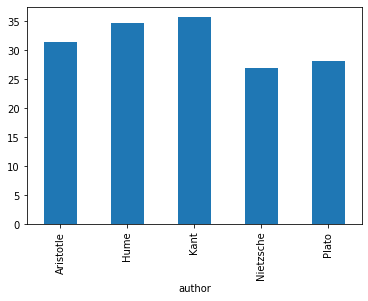

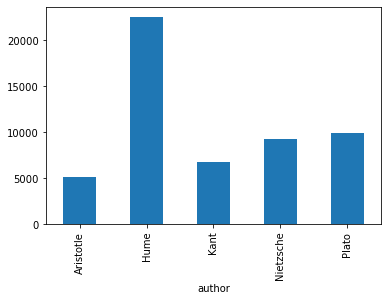

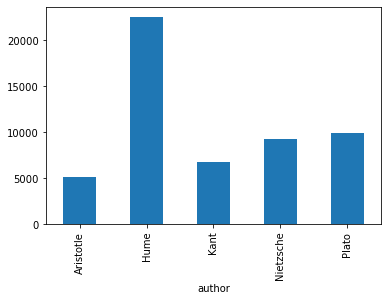

author
Aristotle    3
Hume         1
Kant         0
Nietzsche    4
Plato        2
Name: label, dtype: int64

In [96]:
df_nan = philo_df.isna()
print(df_nan.sum())

# print(philo_df.describe())

philo_df['word_counter'] = philo_df['sentence'].apply(lambda x: x.count(' '))


philo_df.groupby('author')['word_count'].mean().plot.bar()
plt.show()
philo_df.groupby('author')['label'].count().plot.bar()
plt.show()

philo_df.groupby('author')['label'].size().plot.bar()
plt.show()

philo_df.groupby('author')['label'].mean()

In [97]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

first_n_words = 200

def trim_string(x):
    x = x.split(maxsplit=first_n_words)
    x = ' '.join(x[:first_n_words])
    return x

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
PATTERN_S = re.compile("\'s")
PATTERN_RN = re.compile("\\r\\n")
PATTERN_PUNC = re.compile(r"[^\w\s]")
STOPWORDS = set(stopwords.words('english'))
MIN_WORDS = 4

def clean_text(text):
    """
        text: a string
        # TODO What is doing spacy
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = re.sub(PATTERN_S, ' ', text)
    text = re.sub(PATTERN_RN, ' ', text)
    text = re.sub(PATTERN_PUNC, ' ', text)
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub(' ', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', ' ')
    text = re.sub(r'\W+', ' ', text)
    tokens = [w for w in text.split() if not w in STOPWORDS] # remove stopwors from text
    # Remove short words (under 3 characters) from the tokens
    long_words = []
    for token in tokens:
        if len(token) >= MIN_WORDS:
            long_words.append(token)
        else:
            print('remove', token)
    # Join the tokens back together
    cleaned_text = (" ".join(long_words)).strip()
    return cleaned_text

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bettyld/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [98]:
from nltk.stem.porter import *

# Processing the data
# Drop empty text
philo_df.drop(philo_df[philo_df.sentence.str.len()<5].index, inplace=True)

# To try
philo_df['sentence'] = philo_df['sentence'].apply(clean_text)
# trim 
# philo_df['trim_sentence'] = philo_df['sentence'].apply(trim_string)

# To try
# stemmer = PorterStemmer()
# philo_df["sentence"] = philo_df['sentence'].str.split().apply(lambda x: ' '.join([stemmer.stem(w) for w in x]))

mini_philo_df = philo_df[['sentence', 'label']]
mini_philo_df

,sentence,label
19439,the parliament accordingly in the ensuing yea...,1
7039,now in experience our perceptions come togethe...,0
18552,knights and esquires says the dictum of keni...,1
29084,it is come to this plain question whether the...,1
87783,more truly implied namely that practical wis...,3
...,...,...
11603,what are the negative conditions,0
53199,in the same manner the success of a partner re...,1
76766,they both appear to me to be hunters,2
94873,he who is a thorough teacher takes things seri...,4


In [114]:
train_test_ratio = 0.80
train_valid_ratio = 0.80
df_train, df_test = train_test_split(mini_philo_df, train_size = train_test_ratio, random_state = ran_state)
df_train, df_val = train_test_split(mini_philo_df, train_size = train_valid_ratio, random_state = ran_state)

# Write preprocessed data
df_train.to_csv(dl_folder + '/train.csv', index=False)
df_val.to_csv(dl_folder + '/val.csv', index=False)
df_test.to_csv(dl_folder + '/test.csv', index=False)

In [115]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [116]:
from transformers import BertTokenizer, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

In [102]:
import spacy 

BATCH_SIZE = 32 

def generate_bigrams(seq):
    """
    Add bigrams after 1-gram tokens.
    >>> generate_bigrams(['This', 'film', 'is', 'terrible'])
    >>> ['This', 'film', 'is', 'terrible', 'film is', 'is terrible', 'This film']
    """
    n_grams = set(zip(*[seq[i:] for i in range(2)]))
    for n_gram in n_grams:
        seq.append(' '.join(n_gram))
    return seq

# Create Fields
# LABEL = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.long)
# use_vocab=False, not be building our own vocabulary
# tokenize=tokenizer.encode, using pre-trained BERT tokenizer and its corresponding word-to-index mapping
LABEL = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.long)

TEXT = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('sentence', TEXT), ('author', LABEL)]

# Create TabularDataset
train_data, valid_data, test_data = TabularDataset.splits(path=dl_folder, train='train.csv', validation='val.csv', test='test.csv',
                                           format='CSV', fields=fields, skip_header=True)



/Users/bettyld/opt/anaconda3/envs/py37/lib/python3.8/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/Users/bettyld/opt/anaconda3/envs/py37/lib/python3.8/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/Users/bettyld/opt/anaconda3/envs/py37/lib/python3.8/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torcht

In [103]:
print('First instances for training {text, label}', vars(train_data[3]), train_data[3])

First instances for training {text, label} {'sentence': [101, 1997, 2023, 2785, 2003, 1996, 4792, 1997, 7750, 2000, 2256, 6716, 1998, 1997, 8404, 2000, 2256, 2814, 9012, 11516, 1998, 1037, 2261, 2060, 20445, 18923, 2015, 102], 'author': '1'} <torchtext.data.example.Example object at 0x7f8d1c065310>


In [104]:
# Iterators
train_iterator = BucketIterator(train_data, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.sentence),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iterator = BucketIterator(valid_data, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.sentence),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iterator = Iterator(test_data, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)


batch = next(iter(train_iterator))
print('next batch instance according to their respective field', batch, batch.sentence, batch.author)
for data in valid_iterator:
    x, y = data.sentence, data.author
    print(x, y)
    break

next batch instance according to their respective field 
[torchtext.data.batch.Batch of size 32]
	[.sentence]:[torch.LongTensor of size 32x128]
	[.author]:[torch.LongTensor of size 32] tensor([[ 101, 2748, 2002,  ...,    0,    0,    0],
        [ 101, 1045, 2079,  ...,    0,    0,    0],
        [ 101, 5121, 2045,  ...,    0,    0,    0],
        ...,
        [ 101,  102,    0,  ...,    0,    0,    0],
        [ 101,  102,    0,  ...,    0,    0,    0],
        [ 101,  102,    0,  ...,    0,    0,    0]]) tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
        2, 1, 1, 1, 1, 1, 1, 1])
tensor([[  101,  2008,  2003,  ...,     0,     0,     0],
        [  101,  1045,  2812,  ...,     0,     0,     0],
        [  101,  1996, 10721,  ...,     0,     0,     0],
        ...,
        [  101,  1045,  2097,  ...,     0,     0,     0],
        [  101,  2045,  2442,  ...,     0,     0,     0],
        [  101,  2021,  2025,  ...,     0,     0,     0]]) tensor([2, 4, 

/Users/bettyld/opt/anaconda3/envs/py37/lib/python3.8/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/Users/bettyld/opt/anaconda3/envs/py37/lib/python3.8/site-packages/torchtext/data/iterator.py:48: UserWarning: Iterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/Users/bettyld/opt/anaconda3/envs/py37/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will

In [105]:
# Training 
# Save and Load Functions

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [106]:
class BERT(nn.Module):
    """“bert-base-uncased” version of BERT, which is the smaller model trained on lower-cased English text (with 12-layer, 768-hidden, 12-heads, 110M parameters)."""
    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name, num_labels=NUM_LABELS, 
                                                                     output_attentions=False,
                                                                     output_hidden_states=False)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

In [112]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import tqdm 

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def fit(model, it, is_eval=False, optim=None, crit=None):
    epoch_loss = 0
    epoch_acc = 0
    epoch_prec = 0; epoch_rec = 0; epoch_f1 = epoch_prec
    if is_eval:
        model.eval()
    else:
        model.train()
    for batch in tqdm.tqdm(it, total=len(it)):
        if not is_eval:
            optim.zero_grad()
        text = batch.sentence
        text = text.type(torch.LongTensor)
        loss, preds = model(text, batch.author)
#         try:
            
#         except Exception as e:
#             print(e)
#             continue
        acc = accuracy_score(batch.author.cpu().detach().numpy(), np.argmax(preds.cpu().detach().numpy(), axis=1))
        if not is_eval:
            loss.backward()
            optim.step()
        else:
            prec, recall, f1, _ = precision_recall_fscore_support(batch.author.cpu().detach().numpy(), np.argmax(preds.cpu().detach().numpy(), axis=1), average='weighted')
            epoch_prec += prec
            epoch_rec += recall
            epoch_f1 += f1
        epoch_loss += loss.item()
        # epoch_acc += acc.item()
    
    return epoch_loss / len(it), epoch_acc / len(it), epoch_prec / len(it), epoch_rec /len(it), epoch_f1 / len(it)




In [108]:
def train(model,
          optimizer,
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 10,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss, train_acc, _ = fit(model, train_iterator, is_eval=False,
                                    optim=optimizer, crit=criterion)
        valid_loss, valid_acc, val_prec, val_rec, val_f1 = fit(model, valid_iterator, is_eval=True,
                                         crit=criterion)
        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'tut2-model.pt')
       
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
        print(f'\t Val. Pre: {val_prec:.3f} |  Val. Rec: {val_rec*100:.2f}% | Val. F1: {val_f1*100:.2f}%')

    # Last model
    torch.save(model.state_dict(), 'tut2-model.pt')
    print('Finished Training!')

import torch.optim as optim


model = BERT().to(device)
criterion =  nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)
train(model=model, optimizer=optimizer, num_epochs=10)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

TypeError: cannot unpack non-iterable float object

In [109]:
torch.save(model.state_dict(), 'tut2-model_trans.pt')

In [ ]:
# Evaluate

In [113]:
# Evaluate
model.load_state_dict(torch.load('tut2-model_trans.pt'))
test_loss, test_acc, test_prec, test_rec, test_f1 = fit(model, test_iterator, crit=criterion, is_eval=True)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')
print(f'Test prec: {test_prec:.3f} | Test rec: {test_rec*100:.2f}% | Test f1: {test_f1*100:.2f}%')



 19%|█▉        | 65/335 [09:24<39:05,  8.69s/it]


KeyboardInterrupt: 

In [ ]:
# Predict

In [209]:
# glove embed
# from torchtext.vocab import GloVe
# embedding_glove = GloVe(name='6B', dim=100)
import random 

def generate_sentence(n):
    sample = philo_df[['sentence', 'author']].iloc[n%len(philo_df)]
    return sample.sentence, sample.author

def predict(model, sentence):
    model.eval()
    # split one sentence into list of words (smartly splitted by spacy)
    tokenized = generate_bigrams([tok.text for tok in spacy_en.tokenizer(sentence)])
    # Embedded with Glove
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    # Prepare input
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1).transpose(0,1)
    length_tensor = torch.LongTensor(length)
    out = model(tensor, length_tensor)
    out = np.argmax(out.cpu().detach().numpy(), axis=1)[0]
    author_label = LABEL.vocab.stoi[str(out)]
    author_label = enc_aut[author_label]
    return author_label
sentence_ex, label_ex = generate_sentence(random.randint(0, len(philo_df)))
print(sentence_ex, '\n', label_ex)
print('Prediction:', predict(model, sentence_ex))


the difficulti on thi head must encreas when we consid that our judgment alter veri sensibl accord to the subject and that the same power and proxim will be deem possess in one case which is not esteem such in anoth 
 Hume
Prediction: Aristotle


In [164]:
preds =  [[0.48278892, 0.4991066,  0.5182273,  0.50137734, 0.5032032,  0.50438505],
[0.48278892, 0.4991066,  0.5182273,  0.50137734, 0.5032032,  0.50438505]]
np.argmax(preds, axis=1)

array([2, 2])

In [180]:
philo_df[['sentence', 'author']].iloc[2]

sentence    i shall therefor ventur to acknowledg that not...
author                                                   Hume
Name: 23620, dtype: object

In [287]:
len(train_iterator)

3

In [183]:
print(LABEL.vocab.stoi, enc_aut)

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7fdebe9f5160>>, {'<unk>': 0, '1': 1, '2': 2, '4': 3, '0': 4, '3': 5, 1: 0, 3: 0, '[4]': 0, '[1]': 0}) {1: 'Hume', 2: 'Plato', 4: 'Nietzsche', 3: 'Aristotle', 0: 'Kant'}
